# ML Exercise Demo

This notebook contains the first exercise of the Machine Learning for Visual Computing (183.605) lecture at TU Wien. Assignment via TUWEL. Please be aware of the deadlines in TUWEL.

* Upload a zip-file with the required programms. The programming language is python.
    1. Single Layer Perceptron --> `solutions/perceptron.py`
    2. Support Vector Machine --> `solutions/svm.py`
    3. Multi Layer Perceptron --> `solutions/mlp.py`
* If you needed additional conda or pip packages add an anaconda environment.yml to the zip-file
    1. conda env export > environment.yml
    2. See --> https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#sharing-an-environment


##### Conda instructions

1. conda create --name MLVC
2. conda init
3. source ~/.bashrc
4. conda activate MLVC
5. conda install pytorch torchvision torchaudio cudatoolkit=11.6 -c pytorch -c conda-forge
6. conda install -c conda-forge opencv matplotlib tqdm torchinfo pandas

With jupyter notebook:

7. conda install nbformat ipykernel
8. python -m ipykernel install --user --name=MLVC

In [107]:
# juypter magic
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## 1. Settings

This are the global settings.

In [108]:
#Auto reloads all plugins each time they are changed
#   --> See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# General setting for the ipynb
NUM_SAMPLES = 10000   # Number of training samples that will be generated, do not exceed 25.000 on the TUWEL Jupyter Notebooks (will crash kernel)
TEST_RATIO = 0.9       # Percentage of the generated samples that are used for training (rest is used for testing). [0, 1]
BATCH_SIZE = 128       # Batch size for the MLP. Larger batch sizes might improve training, but will require more (GPU-)memory.
EPOCHS_SLP = 100       # Amount of training epochs for the single layer perceptron and svm
EPOCHS_MLP = 100       # Amount of training epochs for the multi layer perceptron

LR_SLP = 0.5           # Learning rate of the SLP and the SVM
LR_MLP = 0.01          # Learning rate of the MLPs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Generate and prepare data

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm, trange
import math

np.set_printoptions(suppress=True)

(9000, 16384) (9000,) (1000, 16384) (1000,)


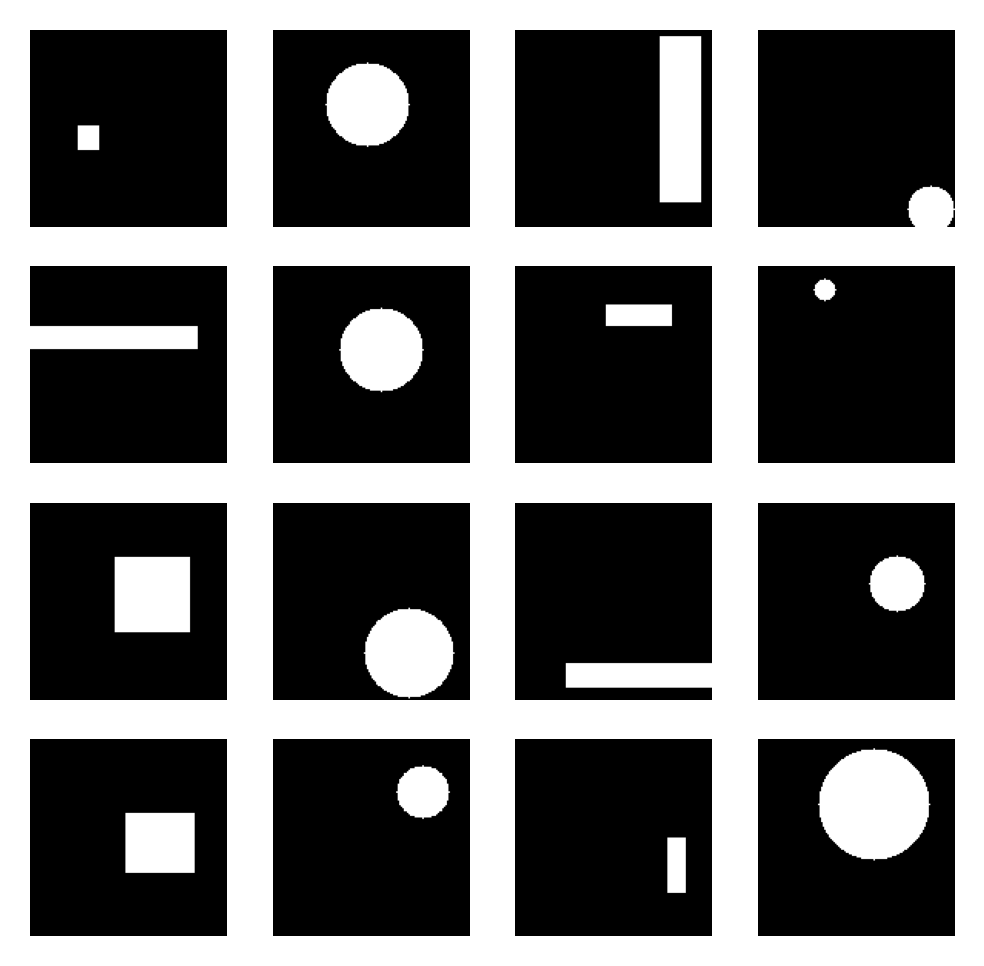

In [110]:
# Generate the dataset using numpy and opencv

from util.generate_dataset import make_dataset
(dataset_train, labels_train), (dataset_test, labels_test) = make_dataset(NUM_SAMPLES, TEST_RATIO)

fig, axs = plt.subplots(4, 4, figsize=(4, 4), dpi=300)

for i, ax in enumerate(axs.reshape(-1)):
    ax.imshow(dataset_train[i,:].reshape((128, 128)), cmap="gray")
    ax.axis('off')

print(dataset_train.shape, labels_train.shape, dataset_test.shape, labels_test.shape)

## 3. Single perceptron

In [111]:
from solutions.perceptron import Perceptron
from sklearn.metrics import confusion_matrix, accuracy_score

100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


[[255 245]
 [190 310]]
Accuracy on the testset: 0.565


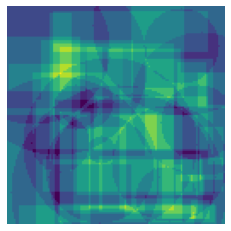

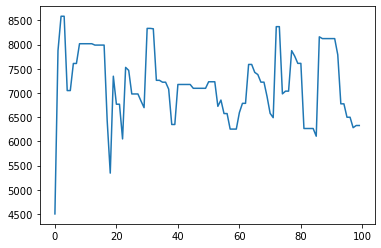

In [112]:
perceptron = Perceptron(lr=LR_SLP)

miss_list = perceptron.fit(dataset_train, labels_train)

y_pred = perceptron.predict(dataset_test)
cm = confusion_matrix(labels_test, y_pred)
print(cm)
acc = accuracy_score(labels_test,y_pred)

print("Accuracy on the testset:", acc)

fig = plt.figure()
plt.imshow(perceptron.w.reshape((128, 128)))
plt.axis('off')
plt.show()

fig = plt.figure()
plt.plot(miss_list)
plt.show()

<div style="background-color:rgba(255, 255, 255, 1); text-align:center; vertical-align: middle; padding:40px 0;">

#### <span style="color:blue">Example weights of the SLP and graph of the missclassifications during training. 100000 Samples, 100 Epochs, 0.5 LR.</span>.
![Example graph of the missclassifications during training, per epoch. 100.000 Samples, 100 Epochs, 0.5 LR.](img/weights_SLP.png) 

![Example weights of the SLP, per epoch. 100000 Samples, 100 Epochs, 0.5 LR.](img/miss_classifications_during_training_SLP.png)

</div>

## 4. SVM

In [113]:
from solutions.svm import SVM
from sklearn.metrics import confusion_matrix, accuracy_score

In [114]:
classifier = SVM()
classifier.fit(dataset_train, labels_train)

y_pred = classifier.predict(dataset_test)
cm = confusion_matrix(labels_test, y_pred)
print(cm)
accuracy_score(labels_test,y_pred)

Setup --- Gaussian kernel --- C: 2 --- epsilon: 0.0002

Iteration 1 - (max iterations: 40)
Current norm value: tensor(58.4808, device='cuda:0') algorithm stops at 0.0002 

Iteration 2 - (max iterations: 40)
Current norm value: tensor(50.9804, device='cuda:0') algorithm stops at 0.0002 

Iteration 3 - (max iterations: 40)
Current norm value: tensor(43., device='cuda:0') algorithm stops at 0.0002 

Iteration 4 - (max iterations: 40)
Current norm value: tensor(35.7771, device='cuda:0') algorithm stops at 0.0002 

Iteration 5 - (max iterations: 40)
Current norm value: tensor(29.2404, device='cuda:0') algorithm stops at 0.0002 

Iteration 6 - (max iterations: 40)
Current norm value: tensor(24.5764, device='cuda:0') algorithm stops at 0.0002 

Iteration 7 - (max iterations: 40)
Current norm value: tensor(19.5192, device='cuda:0') algorithm stops at 0.0002 

Iteration 8 - (max iterations: 40)
Current norm value: tensor(16.7929, device='cuda:0') algorithm stops at 0.0002 

Iteration 9 - (max i

0.708

### Example SVM (Based on SKLEARN)

In [128]:
from sklearn.svm import SVC

classifier = SVC(kernel = 'poly', random_state = 0)
classifier.fit(dataset_train, labels_train)

y_pred = classifier.predict(dataset_test)

cm = confusion_matrix(labels_test, y_pred)
print(cm)
accuracy_score(labels_test,y_pred)

[[330 170]
 [ 19 481]]


0.811

## 5. Multi-layer perceptron

### Convert data to pytorch dataloader for training

In [117]:
from util.convert_dataset_to_pytorch import convert_dataset_to_pytorch


dataloader_train, dataloader_test = convert_dataset_to_pytorch(dataset_train, labels_train, dataset_test, labels_test, batch_size=BATCH_SIZE)

### Multi-layer preceptron implementation (pytorch)

In [125]:
import time
import torch
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

from util.mlp_pytorch import MLP, train, evaluate, vis_loss, vis_weights

In [127]:
model = MLP(16384, 1)

print(summary(model, input_size=(BATCH_SIZE, 16384)))
optimizer = optim.SGD(model.parameters(), lr=LR_MLP)
criterion = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

loss_train_plot = []
loss_test_plot = []
acc_train_plot = []
acc_test_plot = []
input_weights = []
hidden_weights = []
output_weights = []

best_test_loss = float('inf')
with trange(EPOCHS_MLP, position=0, leave=True) as tepoch:
    for epoch in tepoch:
        tepoch.set_description(f"Epoch {epoch}")

        train_loss, train_acc = train(model, dataloader_train, optimizer, criterion, device)
        test_loss, test_acc = evaluate(model, dataloader_test, criterion, device)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), 'weights.pt')

        loss_train_plot.append(train_loss)
        loss_test_plot.append(test_loss)
        acc_train_plot.append(train_acc*100)
        acc_test_plot.append(test_acc*100)

        input_weights.append(model.input_fc.weight.cpu().detach().numpy())
        hidden_weights.append(model.hidden_fc.weight.cpu().detach().numpy())
        output_weights.append(model.output_fc.weight.cpu().detach().numpy())

        tepoch.set_postfix(loss_test=test_loss, accuracy_test=test_acc*100, loss_train=train_loss, accuracy_train=train_acc*100)

Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [128]                     --
├─Linear: 1-1                            [128, 10]                 163,850
├─Linear: 1-2                            [128, 4]                  44
├─Linear: 1-3                            [128, 1]                  5
Total params: 163,899
Trainable params: 163,899
Non-trainable params: 0
Total mult-adds (M): 20.98
Input size (MB): 8.39
Forward/backward pass size (MB): 0.02
Params size (MB): 0.66
Estimated Total Size (MB): 9.06


Epoch 99: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s, accuracy_test=68.1, accuracy_train=68.1, loss_test=0.233, loss_train=0.233]


### Visualize loss

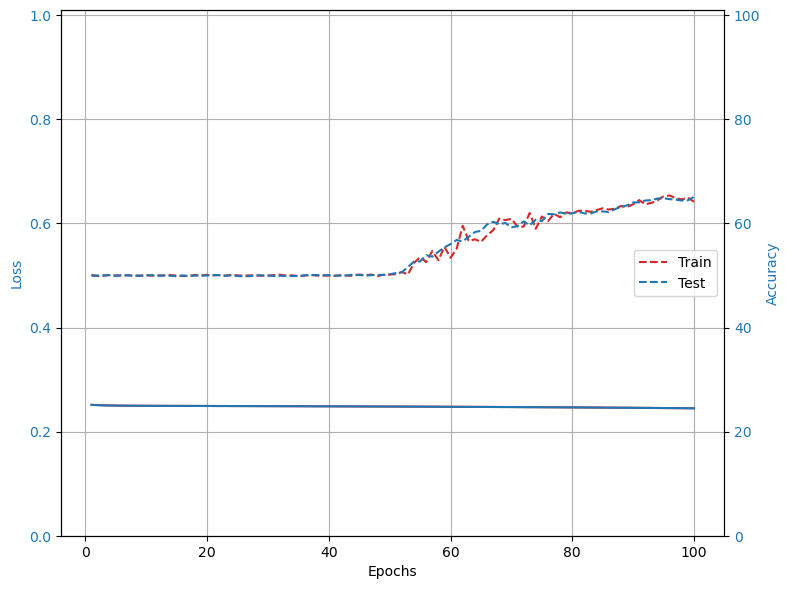

In [120]:
vis_loss(loss_train_plot, loss_test_plot, acc_train_plot, acc_test_plot)

<div style="background-color:rgba(255, 255, 255, 1); text-align:center; vertical-align: middle; padding:40px 0;">

#### <span style="color:blue"> Loss and accuracy graph of the MLP during training (Training- + Testset). 100000 Samples, 100 Epochs, 0.01 LR.</span>.
![h](img/loss_mlp_pytorch.png)

</div>

### Visualize weights

(10, 16384) (4, 10) (1, 4)


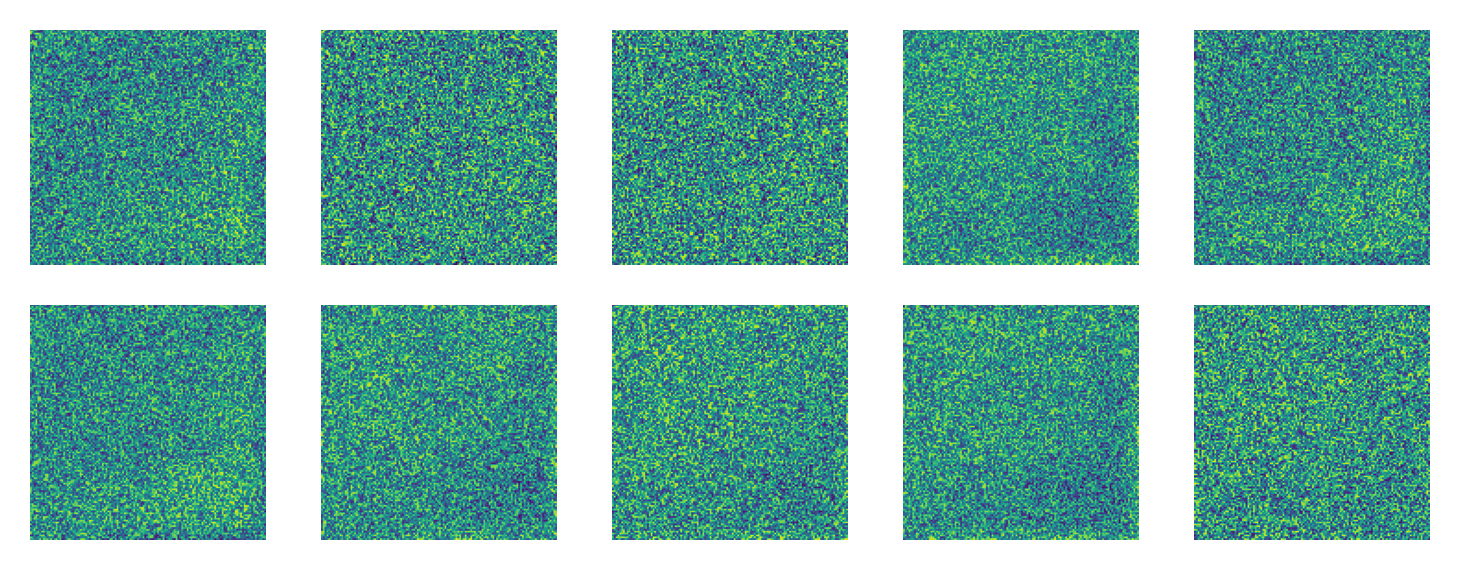

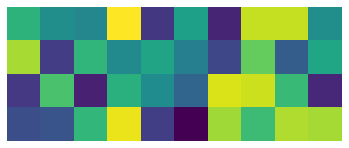

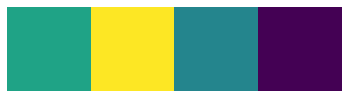

In [121]:
vis_weights(model)

<div style="background-color:rgba(255, 255, 255, 1); text-align:center; vertical-align: middle; padding:40px 0;">

#### <span style="color:blue"> Input weights, MLP Pytorch. 100000 Samples, 100 Epochs, 0.01 LR.</span>.
![h](img/weights_MLP_pytorch_input.png)

#### <span style="color:blue"> Hidden weights, MLP Pytorch. 100000 Samples, 100 Epochs, 0.01 LR.</span>.

![h](img/weights_MLP_pytorch_hidden.png)

#### <span style="color:blue"> Output weights, MLP Pytorch. 100000 Samples, 100 Epochs, 0.01 LR.</span>.

![h](img/weights_MLP_pytorch_output.png)

</div>

## 6. MLP from Scratch

In [123]:
from solutions.mlp import MultiLayerPerceptron

Epoch Error: [0.01240553]: 100%|██████████| 100/100 [05:38<00:00,  3.39s/it]


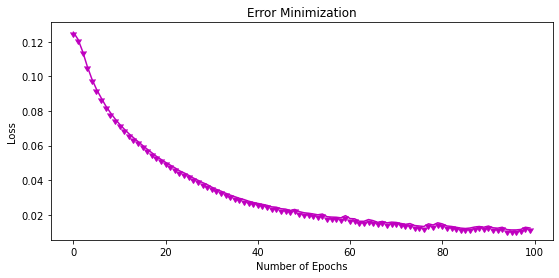

    _id   class  Pred                     Conf  GT
0     0  Square     1     [0.9697493619020666]   1
1     1  Circle     0   [0.004213381349717165]   0
2     2  Square     1     [0.9997043223029864]   1
3     3  Circle     0     [0.3189309727930053]   0
4     4  Square     1      [0.989298292940276]   1
5     5  Circle     0    [0.05145850970443103]   0
6     6  Square     1      [0.960375539852639]   1
7     7  Circle     0    [0.01910893595644346]   0
8     8  Square     1     [0.9881869843944281]   1
9     9  Circle     0   [0.007717515921796471]   0
10   10  Square     1     [0.9992486062312865]   1
11   11  Circle     0  [0.0015185857598221527]   0
12   12  Square     1     [0.9866099987879567]   1
13   13  Circle     0    [0.03571445586759852]   0
14   14  Square     1     [0.9845697365981119]   1
15   15  Circle     0  [0.0012268520068240273]   0
16   16  Square     1      [0.999491572103687]   1
17   17  Circle     0    [0.03858999583204135]   0
18   18  Square     1     [0.94

In [124]:
labels_train[labels_train==-1] = 0
labels_test[labels_test==-1] = 0

Perceptron = MultiLayerPerceptron(epochs=EPOCHS_MLP, activation="sigmoid", lr=LR_MLP)

Perceptron.fit(dataset_train, labels_train)

data_frame, acc = Perceptron.predict(dataset_train, labels_train)

print(data_frame[0:20])
print("Train ACC:", acc)
data_frame, acc = Perceptron.predict(dataset_test, labels_test)
print(data_frame[0:20])
print("Test ACC:", acc)